In [1]:
import os
import sys
import time
import numpy as np
from operator import itemgetter
from itertools import chain, islice
from functools import partial
from joblib import delayed, Parallel
import random
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')



# logic to accomodate Google Colab
try:
    import google.colab

    ENV_IS_CL = True
    
    root = r"/content/t-route"
    subprocess.run(["git", "clone", "https://github.com/NOAA-OWP/t-route.git"])
    sys.path.append("/content/t-route/src/python_framework_v02")
    sys.path.append("/content/t-route/src/python_routing_v02")
    
    fortran_source_dir = os.path.join(root, "src", "fortran_routing", "mc_pylink_v00", "MC_singleSeg_singleTS")
    sys.path.append(fortran_source_dir)

    ! pip install geopandas
    ! pip install netcdf4

    # change current working directory to /notebooks
    os.chdir("/content/t-route/notebooks")
    
except:
    ENV_IS_CL = False
    
    root = os.path.dirname(os.path.abspath(""))
    fortran_source_dir = os.path.join(root, "src", "fortran_routing", "mc_pylink_v00", "MC_singleSeg_singleTS")
    sys.path.append(fortran_source_dir)
    sys.path.append(os.path.join(root, "src", "python_framework_v02"))
    sys.path.append(os.path.join(root, "src", "python_routing_v02"))

## network/reach utilities & routing module
import nhd_network_utilities_v02 as nnu
import nhd_io
import nhd_network
import mc_reach

# River network wave routing with t-route
This notebook illustrates how the t-route code base routes flood waves through large river networks. We created an experiment where a  pulse of lateral inflows is uniformly applied to and routed through the CONUS mainstem supernetwork. Experiment results are visulalized for Mississippi River Basin. 

We begin by specifying the time domain of our experiment. We need to make sure the simulation is long enough to observe a near complete drainage of very large river basins. Additionally, the timestep should be short enough to avoid numerical instabilities and capture relevant flow variations, yet long enough to minimize the computational burden. 

In [2]:
# number of simulated timesteps
nts = 8000

# duration of each timestep (seconds)
dt = 1800

print("The total simulated time is %s days" % (nts * dt /60 / 60 / 24))   

The total simulated time is 166.66666666666666 days


# Identify supernetwork connections
The next step is to identify the supernetwork that we will focus on for this experiment and analyze the connectivity of individual segments in the network. Here we are using the CONUS mainstems super network. Additional details related to network analysis subroutines can be found in a companion notebook: `network-analysis.ipnyb`

In [3]:
print("Identifying supernetwork connections set")

test_folder = os.path.join(root, r"test")
geo_input_folder = os.path.join(test_folder, r"input", r"geo")
supernetwork = 'Mainstems_CONUS'

network_data = nnu.set_supernetwork_data(
    supernetwork=supernetwork, geo_input_folder=geo_input_folder
)

# select only the necessary columns of geospatial data, set the DataFrame index
cols = [v for c, v in network_data.items() if c.endswith("_col")]
data = nhd_io.read(network_data["geo_file_path"])
data = data[cols]
data = data.set_index(network_data["key_col"])

# mask NHDNetwork to isolate test network of choice
if "mask_file_path" in network_data:
    data_mask = nhd_io.read_mask(
        network_data["mask_file_path"],
        layer_string=network_data["mask_layer_string"],
    )
    data = data.filter(data_mask.iloc[:, network_data["mask_key"]], axis=0)

# sort index
data = data.sort_index()

# replace downstreams
data = nhd_io.replace_downstreams(data, network_data['downstream_col'], 0)

# extract downstream connections for each node
connections = nhd_network.extract_connections(data, network_data["downstream_col"])

print("supernetwork connections set created.")

Identifying supernetwork connections set
supernetwork connections set created.


# Organize supernetwork into subnetworks and reaches
Once the supernetwork is identified and analyzed, we proceed by breaking the supernetwork into computationally independent subnetworks, and further breaking subnetworks into reaches. Additional details regarding this step can be found in a companion notebook: `network-analysis.ipnyb` 

In [4]:
print("Organizing segments into reaches.")

# reverse the network - track upstream connections
rconn = nhd_network.reverse_network(connections)

# isolate independent subnetworks
subnets = nhd_network.reachable_network(rconn)

# identify the segments in each subnetwork
subreachable = nhd_network.reachable(rconn)

# break each subnetwork into reaches 
subreaches = {}
for tw, net in subnets.items():
    path_func = partial(nhd_network.split_at_junction, net)
    subreaches[tw] = nhd_network.dfs_decomposition(net, path_func)  

print("Reach creation complete.")    

Organizing segments into reaches.
Reach creation complete.


# Create a lateral inflow series
In our experiment we will load the river network with a pulse of lateral inflows and observe how the network fills and drains in response. The function `step_lats` below divides the time domain into ten equal intervals. A pulse of lateral inflows is applied to the second and third intervals. You can replace this function with another function of your choice, or simulated lateral flows from a hydrologic model.

*eventually, we would like to have the routing scheme accept lateral inflow data from WRF-hydro. So long as these data can be formatted into a DataFrame similar to `qlats`, there should be no problems*

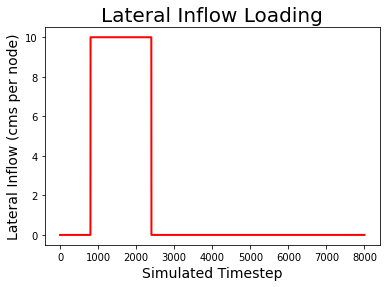

In [5]:
def step_qlats(data, nsteps, qlat):
    
    q1 = np.full((len(data.index), nsteps//10), 0, dtype='float32')
    q2 = np.full((len(data.index), nsteps//10), qlat, dtype='float32')
    q3 = np.full((len(data.index), nsteps//10), qlat, dtype='float32')
    q4 = np.full((len(data.index), nsteps//10), 0, dtype='float32')
    q5 = np.full((len(data.index), nsteps//10), 0, dtype = 'float32')
    q6 = np.full((len(data.index), nsteps//10), 0, dtype='float32')
    q7 = np.full((len(data.index), nsteps//10), 0, dtype='float32')
    q8 = np.full((len(data.index), nsteps//10), 0, dtype='float32')
    q9 = np.full((len(data.index), nsteps//10), 0, dtype='float32')
    q10 = np.full((len(data.index), nsteps//10), 0, dtype='float32')
    
    q= np.concatenate((q1,q2,q3,q4,q5,q6,q7,q8,q9,q10),axis=1)
    
    ql = pd.DataFrame(q, index=data.index, columns=range(nsteps))
    
    return ql

# create the lateral inflow data
qlats = step_qlats(data, nts, 10.0)

# plot lateral inflow series
 # plot the timeseris of lateral inflow loading
qlats.iloc[1].plot(color = 'r', linewidth = 2)

ax = plt.gca()
ax.set_title("Lateral Inflow Loading", size = 20)
ax.set_ylabel("Lateral Inflow (cms per node)", size = 14)
ax.set_xlabel("Simulated Timestep", size = 14)

plt.show()

# Execute Muskingum-Cunge model over the Mississippi River Basin
Now that we have analyzed the network and specified lateral inflows, we can go ahead and compute the routing. Here, we compute routing through a single subnetwork, the Mississippi River Basin, as an example. In practice `mc_reach.compute_network` is called for each subnetwork in the supernetwork in the context of a for-loop. 

`mc_reach.compute_network` calls the Muskingum-Cunge model for each segment of each reach in the network. Reaches are evaluated in an upstream-to-downstream order and reach connections are tracked to maintain mass balance at reach intersections and junctions. 

### *note*
mc_reach is a cython c-extension for Python. To use this function, we must first create shared object files that can be easily called by Python.  See `t-route/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/compile_singleSeg_cython.md` for instructions on how to do this. 

In [16]:
# initialize a results matrix
results = []

# Isolate the Mississippi River Basin from the supernetwork
tw = 22811611  # this is the tailwater ID of the Mississippi Basin, ! TODO - a better way to index basins by name...  
reach = subreaches[tw]    

start_time = time.time()
print("Conducting routing computations for the Mississippi River Basin - this may take a while...")

# get a list of segments in the subnetwork
r =list(chain.from_iterable(reach)) 

# prep parameter and lateral inflow data to be fed to routing model
data_sub = data.loc[r, ['dt', 'bw', 'tw', 'twcc', 'dx', 'n', 'ncc', 'cs', 's0']].sort_index()
qlat_sub = qlats.loc[r].sort_index()
  
# compute the network routing, calculate (flow, depth, and velocity)    
results.append(mc_reach.compute_network(
    nts, reach, subnets[tw], data_sub.index.values, data_sub.columns.values, data_sub.values, qlat_sub.values
    )
)

# create a multi-index DataFrame with flow, depth, and velocity simulations
fdv_columns = pd.MultiIndex.from_product([range(nts), ['q', 'v', 'd']])
flowveldepth = pd.concat([pd.DataFrame(d, index=i, columns=fdv_columns) for i, d in results], copy=False)
flowveldepth = flowveldepth.sort_index()

print("Routing computations complete!")
print("... in %s minutes." % (time.time() - start_time)/60)

Conducting routing computations for the Mississippi River Basin - this may take a while...
Routing computations complete!
... in 472.26661705970764 seconds.


# Extract simulated flow data for each segment in the Mississippi River Basin subnetwork

In [18]:
# grab simulated flows for all segments in the network
# [i, j, k]:
# i = index values for each segment
# j = all times
# k = the parameter of interest
network_flows = flowveldepth.loc[:, (slice(None), 'q')]

# Create a GeoDataFrame for viz purposes

In [19]:
# create a GeoDataFrame of points for each link in the stream network
dat_geo = nhd_io.read(network_data["geo_file_path"])
dat_geo = dat_geo.set_index(network_data["key_col"])

if "mask_file_path" in network_data:
        data_mask = nhd_io.read_mask(
            network_data["mask_file_path"],
            layer_string=network_data["mask_layer_string"],
        )
        dat_geo = dat_geo.filter(data_mask.iloc[:, network_data["mask_key"]], axis=0)

# create a GeoData Frame        
gdf = geopandas.GeoDataFrame(dat_geo, geometry=geopandas.points_from_xy(dat_geo.lon, dat_geo.lat))

# clip the GeoDataFrame to include ONLY segments in the specified river network
network_segs = subreachable[tw]
network_gdf = gdf.loc[gdf.index.isin(network_segs)]

# Create an animation showing flow changes through space and time

In [ ]:
import gif
from mpl_toolkits.axes_grid1 import make_axes_locatable

# network geodata framee
network_gdf = gdf.loc[gdf.index.isin(network_segs)]

@gif.frame
def plot(tstep):
    
    first_flow = network_flows.loc[:, ((tstep), 'q')]
 
    joined_gdf = network_gdf.join(first_flow)
    joined_gdf = joined_gdf.rename(columns = {joined_gdf.columns[-1] : 'flow'})
    
    # create a figure showing spatial variations in simulated flow and the lateral flow loading
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(4, 3)
    ax1 = fig.add_subplot(gs[0:2, :]) # we will make a map on ax1
    ax2 = fig.add_subplot(gs[2:3,:])  # we will make a line plot on ax2

    # need to adjust the size and position of the map colorbar
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # plot the spatial variation in simulated flow rate, across all stream segments in the network
    joined_gdf.plot(markersize = 5, 
                    column = "flow", 
                    cmap = 'PuBu', 
                    legend = True, 
                    vmin = 0, 
                    vmax = 20000,
                    ax = ax1, 
                    cax = cax, 
                    legend_kwds={'label': "Flow (cms)",
                             'orientation': "vertical"})

    # map title and axis controls
    ax1.set_title("Mississippi River Basin", size = 20)
    ax1.axis('off')

    # plot the timeseris of lateral inflow loading
    qlats.iloc[1][0:tstep].plot(ax = ax2, color = 'r', linewidth = 2) # ! make the 5 = tstep
    ax2.set_xlim([0, 8000])
    ax2.set_ylim([0, 11])
    ax2.set_title("Lateral Inflow Loading", size = 20)
    ax2.set_ylabel("Lateral Inflow (cms per node)", size = 14)
    ax2.set_xlabel("Simulated Timestep", size = 14)

    # adjsut the figure size
    fig.set_size_inches(10, 10)

frames = []
for i in range(0,8000,100):
    
    frame = plot(i)
    
    frames.append(frame)

gif.save(frames, "../doc/mississippi.gif", duration = 10)